## Solar Orbiter data for 2022 Sep CME event

use environment helio3




In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.dates import  DateFormatter
import datetime
from datetime import timedelta
import time
import pickle
import seaborn as sns

import astropy
import astropy.constants as const
import astropy.units as u
import astroquery  
import sunpy
from sunpy.coordinates import frames, get_horizons_coord
from sunpy.time import parse_time
import astrospice

import heliopy.data.spice as spicedata
import heliopy.spice as spice



import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
import cdflib


import warnings
warnings.filterwarnings('ignore')


#import heliosat

#on mac
sys.path.append('/Users/chris/python/heliocats')

from heliocats import plot as hp
#importlib.reload(hp) #reload again while debugging

#from heliocats import data as hd
#importlib.reload(hd) #reload again while debugging

#from heliocats import cats as hc
#importlib.reload(hc) #reload again while debugging

#from heliocats import stats as hs
#importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 

import config
importlib.reload(config)
from config import data_path
from config import data_path_ML


plt.rcParams["figure.figsize"] = (15,5)


from astropy.constants import au
AU=au.value/1e3 #in km

from astropy.constants import R_sun
RS=R_sun.value*1e-3 #in km

print('done')

/Users/chris/anaconda3/envs/helio3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


done



### read SolO/SWA plasma data (science level 2) - use case 2022 Sep 5 CME

Exception ignored in: <function CDF.__del__ at 0x7ff14de69d30>
Traceback (most recent call last):
  File "/Users/chris/anaconda3/envs/helio3/lib/python3.9/site-packages/cdflib/cdfread.py", line 182, in __del__
    if self.temp_file is not None:
AttributeError: 'CDF' object has no attribute 'temp_file'


done
{'Item_Size': 4, 'Data_Type': 'CDF_CHAR', 'Num_Items': 1, 'Data': 'km/s'}
{'Item_Size': 15, 'Data_Type': 'CDF_CHAR', 'Num_Items': 1, 'Data': 'particles cm^-3'}
{'Item_Size': 2, 'Data_Type': 'CDF_CHAR', 'Num_Items': 1, 'Data': 'eV'}


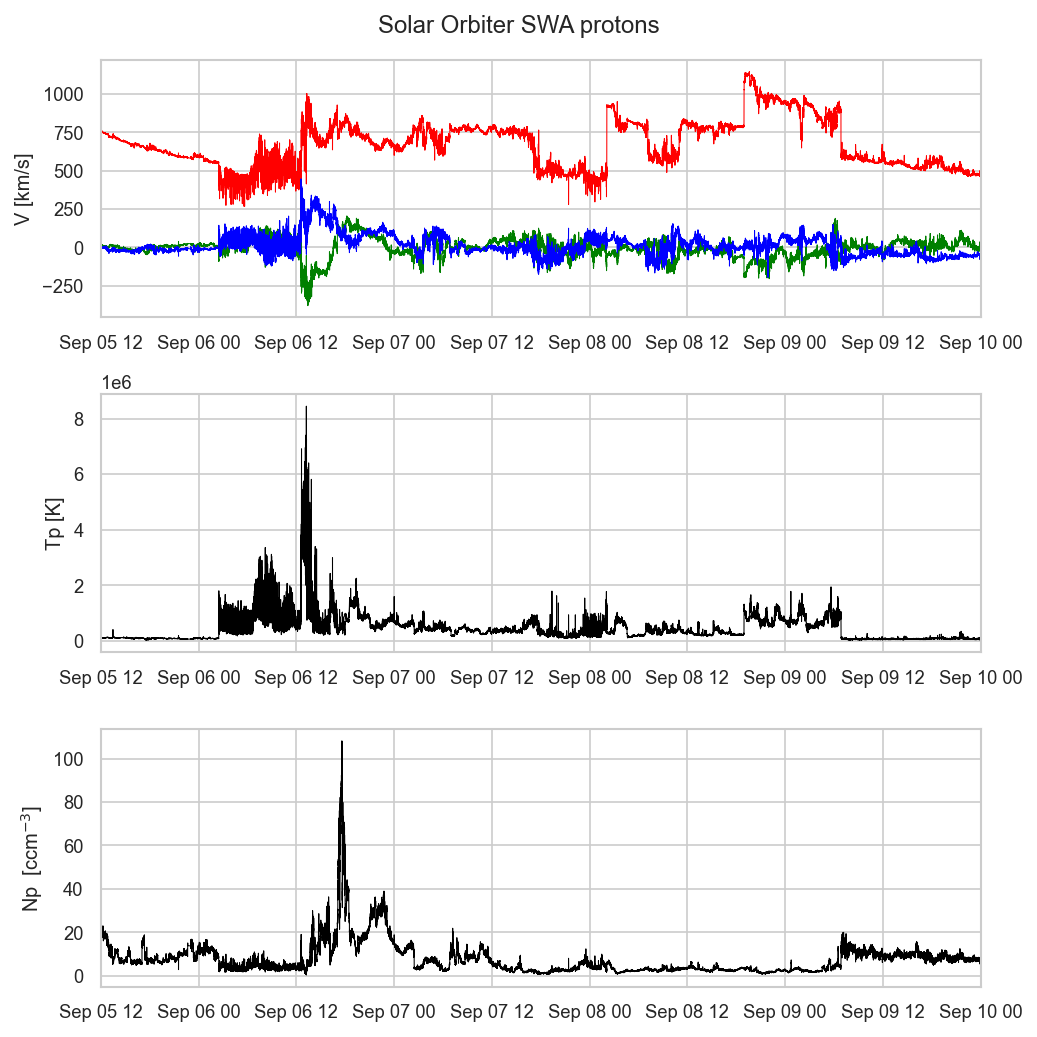

In [5]:
sns.set_style('whitegrid')
sns.set_context('paper')

%matplotlib inline

#locally on Macbook
ll_path = "../data/solo_swa_2022sep"

files = os.listdir(ll_path)
files.sort()
llfiles = [os.path.join(ll_path, f) for f in files]
#print(llfiles)

timep=np.zeros(0,dtype=[('time',object)])
den=np.zeros(0)
temp=np.zeros(0)
vr=np.zeros(0)
vt=np.zeros(0)
vn=np.zeros(0)


for i in np.arange(0,len(llfiles)):
    p1 = cdflib.CDF(llfiles[i])
    #p1.cdf_info()

    den1=p1.varget('N')
    speed1=p1.varget('V_RTN')
    temp1=p1.varget('T')

    vr1=speed1[:,0]
    vt1=speed1[:,1]
    vn1=speed1[:,2]
    
    vr=np.append(vr1,vr)
    vt=np.append(vt1,vt)
    vn=np.append(vn1,vn)
    
    
    temp=np.append(temp1,temp)
    den=np.append(den1,den)

    
    time1=p1.varget('EPOCH')
    t1=parse_time(cdflib.cdfastropy.convert_to_astropy(time1, format=None)).datetime
    timep=np.append(timep,t1)
    #print(time1)


temp=temp*(1.602176634*1e-19)/(1.38064852*1e-23) # from ev to K 



plt.figure(1,figsize=(7,7),dpi=150)

ax1 = plt.subplot(311) 

plt.suptitle('Solar Orbiter SWA protons')
plt.plot(timep, vr, 'r',lw=0.5)
plt.plot(timep, vt, 'g',lw=0.5)
plt.plot(timep, vn, 'b',lw=0.5)
plt.ylabel('V [km/s]')

ax2 = plt.subplot(312) 
plt.plot(timep, temp, 'k', lw=0.5)
plt.ylabel('Tp [K]')

ax3 = plt.subplot(313) 
plt.plot(timep, den, 'k', lw=0.5)
plt.ylabel(r'Np  [ccm$^{-3}$]')


plotstart=datetime.datetime(2022,9,5,12)
plotend=datetime.datetime(2022,9,10,0)
ax1.set_xlim(plotstart,plotend)
ax2.set_xlim(plotstart,plotend)
ax3.set_xlim(plotstart,plotend)

date_form = DateFormatter("%h %d %H")
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)
ax3.xaxis.set_major_formatter(date_form)


plt.tight_layout()

#plt.savefig('lineups/solo_2022_sep_plasma.png')
#plt.savefig('lineups/solo_2022_sep_plasma.pdf')

print('done')

print(p1.attget('UNITS','V_RTN'))
print(p1.attget('UNITS','N'))
print(p1.attget('UNITS','T'))



### read SolO MAG data (preliminary) - use case 2022 Sep 5 CME

In [6]:
#locally on Macbook
ll_path = "../data/solo_mag_2022sep"
#ll_path = "/nas/helio/data/SolarOrbiter/MAG/low_latency/"

files = os.listdir(ll_path)
files.sort()
llfiles = [os.path.join(ll_path, f) for f in files]
print(llfiles)

llfiles=llfiles[1:-1]

['../data/solo_mag_2022sep/.DS_Store', '../data/solo_mag_2022sep/solo_L2_mag-rtn-normal-1-minute-formagonly_20220902_V00.cdf', '../data/solo_mag_2022sep/solo_L2_mag-rtn-normal-1-minute-formagonly_20220903_V00.cdf', '../data/solo_mag_2022sep/solo_L2_mag-rtn-normal-1-minute-formagonly_20220904_V00.cdf', '../data/solo_mag_2022sep/solo_L2_mag-rtn-normal-1-minute-formagonly_20220905_V00.cdf', '../data/solo_mag_2022sep/solo_L2_mag-rtn-normal-1-minute-formagonly_20220906_V00.cdf', '../data/solo_mag_2022sep/solo_L2_mag-rtn-normal-1-minute-formagonly_20220907_V00.cdf', '../data/solo_mag_2022sep/solo_L2_mag-rtn-normal-1-minute-formagonly_20220908_V00.cdf', '../data/solo_mag_2022sep/solo_L2_mag-rtn-normal-1-minute-formagonly_20220909_V00.cdf']


In [7]:
br1=np.zeros(0)
bt1=np.zeros(0)
bn1=np.zeros(0)
time1=np.zeros(0,dtype=[('time',object)])


for i in np.arange(0,len(llfiles)):
    m1 = cdflib.CDF(llfiles[i])
    #print(m1.cdf_info())


    b=m1.varget('B_RTN')
    br=b[:,0]
    bt=b[:,1]
    bn=b[:,2]
    
    br1=np.append(br1,br)
    bt1=np.append(bt1,bt)
    bn1=np.append(bn1,bn)

    time=m1.varget('EPOCH')

    t1=parse_time(cdflib.cdfastropy.convert_to_astropy(time, format=None)).datetime
    time1=np.append(time1,t1)

        
print(m1.attget('UNITS','B_RTN')) 


    
#define datetime object for 1 minute resolution    
starttime = datetime.datetime(2022, 9, 1)
endtime = datetime.datetime(2022, 9,12)
time_int = []
while starttime < endtime:
        time_int.append(starttime)
        starttime += timedelta(minutes=1)

        
time_int_mat=mdates.date2num(time_int)
time1_mat=mdates.date2num(time1)
timep_mat=mdates.date2num(timep)        

solo_ll=np.zeros(np.size(time_int),dtype=[('time',object),('bx', float),('by', float),\
            ('bz', float),('bt', float),('r', float),('lat', float),('lon', float),\
            ('x', float),('y', float),('z', float),('vx', float),\
            ('vy', float),('vz', float),('vt', float),('tp', float),('np', float) ] )   

solo_ll = solo_ll.view(np.recarray)  


solo_ll.time=time_int
solo_ll.bx=np.interp(time_int_mat, time1_mat,br1)
solo_ll.by=np.interp(time_int_mat, time1_mat,bt1)
solo_ll.bz=np.interp(time_int_mat, time1_mat,bn1)
solo_ll.bt=np.sqrt(solo_ll.bx**2+solo_ll.by**2+solo_ll.bz**2)


solo_ll.np=np.interp(time_int_mat, timep_mat,den)
solo_ll.tp=np.interp(time_int_mat, timep_mat,temp) 
solo_ll.vx=np.interp(time_int_mat, timep_mat,vr)
solo_ll.vy=np.interp(time_int_mat, timep_mat,vt)
solo_ll.vz=np.interp(time_int_mat, timep_mat,vn)
solo_ll.vt=np.sqrt(solo_ll.vx**2+solo_ll.vy**2+solo_ll.vz**2)


#spacecraft position with astrospice
kernels = astrospice.registry.get_kernels('solar orbiter', 'predict')
solo_kernel = kernels[0]

solo_coords = astrospice.generate_coords('solar orbiter', time_int)
solo_coords_heeq = solo_coords.transform_to(sunpy.coordinates.HeliographicStonyhurst())

solo_ll.lon=solo_coords_heeq.lon.value
solo_ll.lat=solo_coords_heeq.lat.value
solo_ll.r=solo_coords_heeq.radius.to(u.au).value


filename='solo_2022_sep_mag_swa_science.p'
pickle.dump(solo_ll, open(data_path+filename, "wb"))
print('done')

print(data_path+filename)

{'Item_Size': 2, 'Data_Type': 'CDF_UCHAR', 'Num_Items': 1, 'Data': 'nT'}


Files Downloaded: 100%|█████████████████████████| 1/1 [00:00<00:00,  3.82file/s]


done
data/solo_2022_sep_mag_swa_science.p


### plot SolO data 2022 Sep 5 CME

In [8]:
print('load Solar Orbiter low lat RTN and plasma ')
filename='solo_2022_sep_mag_swa_science.p'
solo=pickle.load(open(data_path+filename, "rb" ) )  

load Solar Orbiter low lat RTN and plasma 


In [9]:
### measure
%matplotlib
plt.ion()

from heliocats import plot as hp
hp.plot_insitu_measure(solo, '2022-Sep-5','2022-Sep-10', 'solo', 'results/')


Using matplotlib backend: <object object at 0x7ff149bb3200>


In [22]:
icme_start_time=parse_time('2022-09-06T12:33Z').datetime
mo_start_time=parse_time('2022-09-07T00:36Z').datetime
mo_end_time=parse_time('2022-09-08T04:11Z').datetime


#interface at 2022-09-07T20:55Z

print('SolO times:',icme_start_time, mo_start_time,mo_end_time)


print()
#index of times
icme_start_ind=np.where(solo.time>icme_start_time)[0][0]
mo_start_ind=np.where(solo.time>mo_start_time)[0][0]
mo_end_ind=np.where(solo.time>mo_end_time)[0][0]


print('HEEQ position of SolO r/lat/lon at icme_start_time:',np.round(solo.r[icme_start_ind],3),np.round(solo.lat[icme_start_ind],2),np.round(solo.lon[icme_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_start_time:',np.round(solo.r[mo_start_ind],3),np.round(solo.lat[mo_start_ind],2),np.round(solo.lon[mo_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_end_time:',np.round(solo.r[mo_end_ind],3),np.round(solo.lat[mo_end_ind],2),np.round(solo.lon[mo_end_ind],2))

print()

print('SolO ICME duration hours ', np.round((mo_end_time-icme_start_time).total_seconds()/3600,2))
print('SolO sheath duration hours ', np.round((mo_start_time-icme_start_time).total_seconds()/3600,2))
print('SolO MO duration hours ', np.round((mo_end_time-mo_start_time).total_seconds()/3600,2))
print()


print('SOLO Bmean ICME   ',np.round(np.nanmean(solo.bt[icme_start_ind:mo_end_ind]),2), ' nT')
print('SOLO Bmean sheath ',np.round(np.nanmean(solo.bt[icme_start_ind:mo_start_ind]),2),' nT')
print('SOLO Bmean MO     ',np.round(np.nanmean(solo.bt[mo_start_ind:mo_end_ind]),2),' nT')

print()
print('SOLO Bmax ICME   ',np.round(np.nanmax(solo.bt[icme_start_ind:mo_end_ind]),2), ' nT')
print('SOLO Bmax sheath ',np.round(np.nanmax(solo.bt[icme_start_ind:mo_start_ind]),2),' nT')
print('SOLO Bmax MO     ',np.round(np.nanmax(solo.bt[mo_start_ind:mo_end_ind]),2),' nT')

print()
print()

print('SOLO Vmean ICME   ',np.round(np.nanmean(solo.vt[icme_start_ind:mo_end_ind]),1), 'km/s')
print('SOLO Vmean sheath ',np.round(np.nanmean(solo.vt[icme_start_ind:mo_start_ind]),1),'km/s')
print('SOLO Vmean MO     ',np.round(np.nanmean(solo.vt[mo_start_ind:mo_end_ind]),1),' km/s')


print()
print('SOLO Vmax ICME   ',np.round(np.nanmax(solo.vt[icme_start_ind:mo_end_ind]),1), ' km/s')
print('SOLO Vmax sheath ',np.round(np.nanmax(solo.vt[icme_start_ind:mo_start_ind]),1),' km/s')
print('SOLO Vmax MO     ',np.round(np.nanmax(solo.vt[mo_start_ind:mo_end_ind]),1),' km/s')


print()


print('assume launch Sep 5 18:45 at 14.72 Rs as the CME impacts PSP')
print('arrival SolO Sep 6 12:33 at', np.round(solo.r[icme_start_ind],3), ' AU')    

launch_time=datetime.datetime(2022,9,5,18,45,0)
transit_time=icme_start_time-launch_time
transit_dist=solo.r[icme_start_ind]-14.72*RS/AU

transit_speed=transit_dist*149.5e6/(transit_time.seconds)


print('Transit time hours', transit_time.seconds/3600)
print('Transit distance AU',np.round(transit_dist,5))

print('Average transit speed',np.int(transit_speed),'km/s')
  
    
print(solo.lat)


SolO times: 2022-09-06 12:33:00 2022-09-07 00:36:00 2022-09-08 04:11:00

HEEQ position of SolO r/lat/lon at icme_start_time: 0.694 -3.64 149.69
HEEQ position of SolO r/lat/lon at mo_start_time: 0.689 -3.74 149.89
HEEQ position of SolO r/lat/lon at mo_end_time: 0.677 -3.98 150.38

SolO ICME duration hours  39.63
SolO sheath duration hours  12.05
SolO MO duration hours  27.58

SOLO Bmean ICME    14.21  nT
SOLO Bmean sheath  16.43  nT
SOLO Bmean MO      13.08  nT

SOLO Bmax ICME    36.95  nT
SOLO Bmax sheath  36.95  nT
SOLO Bmax MO      23.78  nT


SOLO Vmean ICME    698.4 km/s
SOLO Vmean sheath  760.7 km/s
SOLO Vmean MO      671.2  km/s

SOLO Vmax ICME    1024.4  km/s
SOLO Vmax sheath  1024.4  km/s
SOLO Vmax MO      944.4  km/s

assume launch Sep 5 18:45 at 14.72 Rs as the CME impacts PSP
arrival SolO Sep 6 12:33 at 0.694  AU
Transit time hours 17.8
Transit distance AU 0.62577
Average transit speed 1459 km/s
[-2.94724273 -2.94729016 -2.94733759 ... -4.80387656 -4.80403147
 -4.80418639]


done


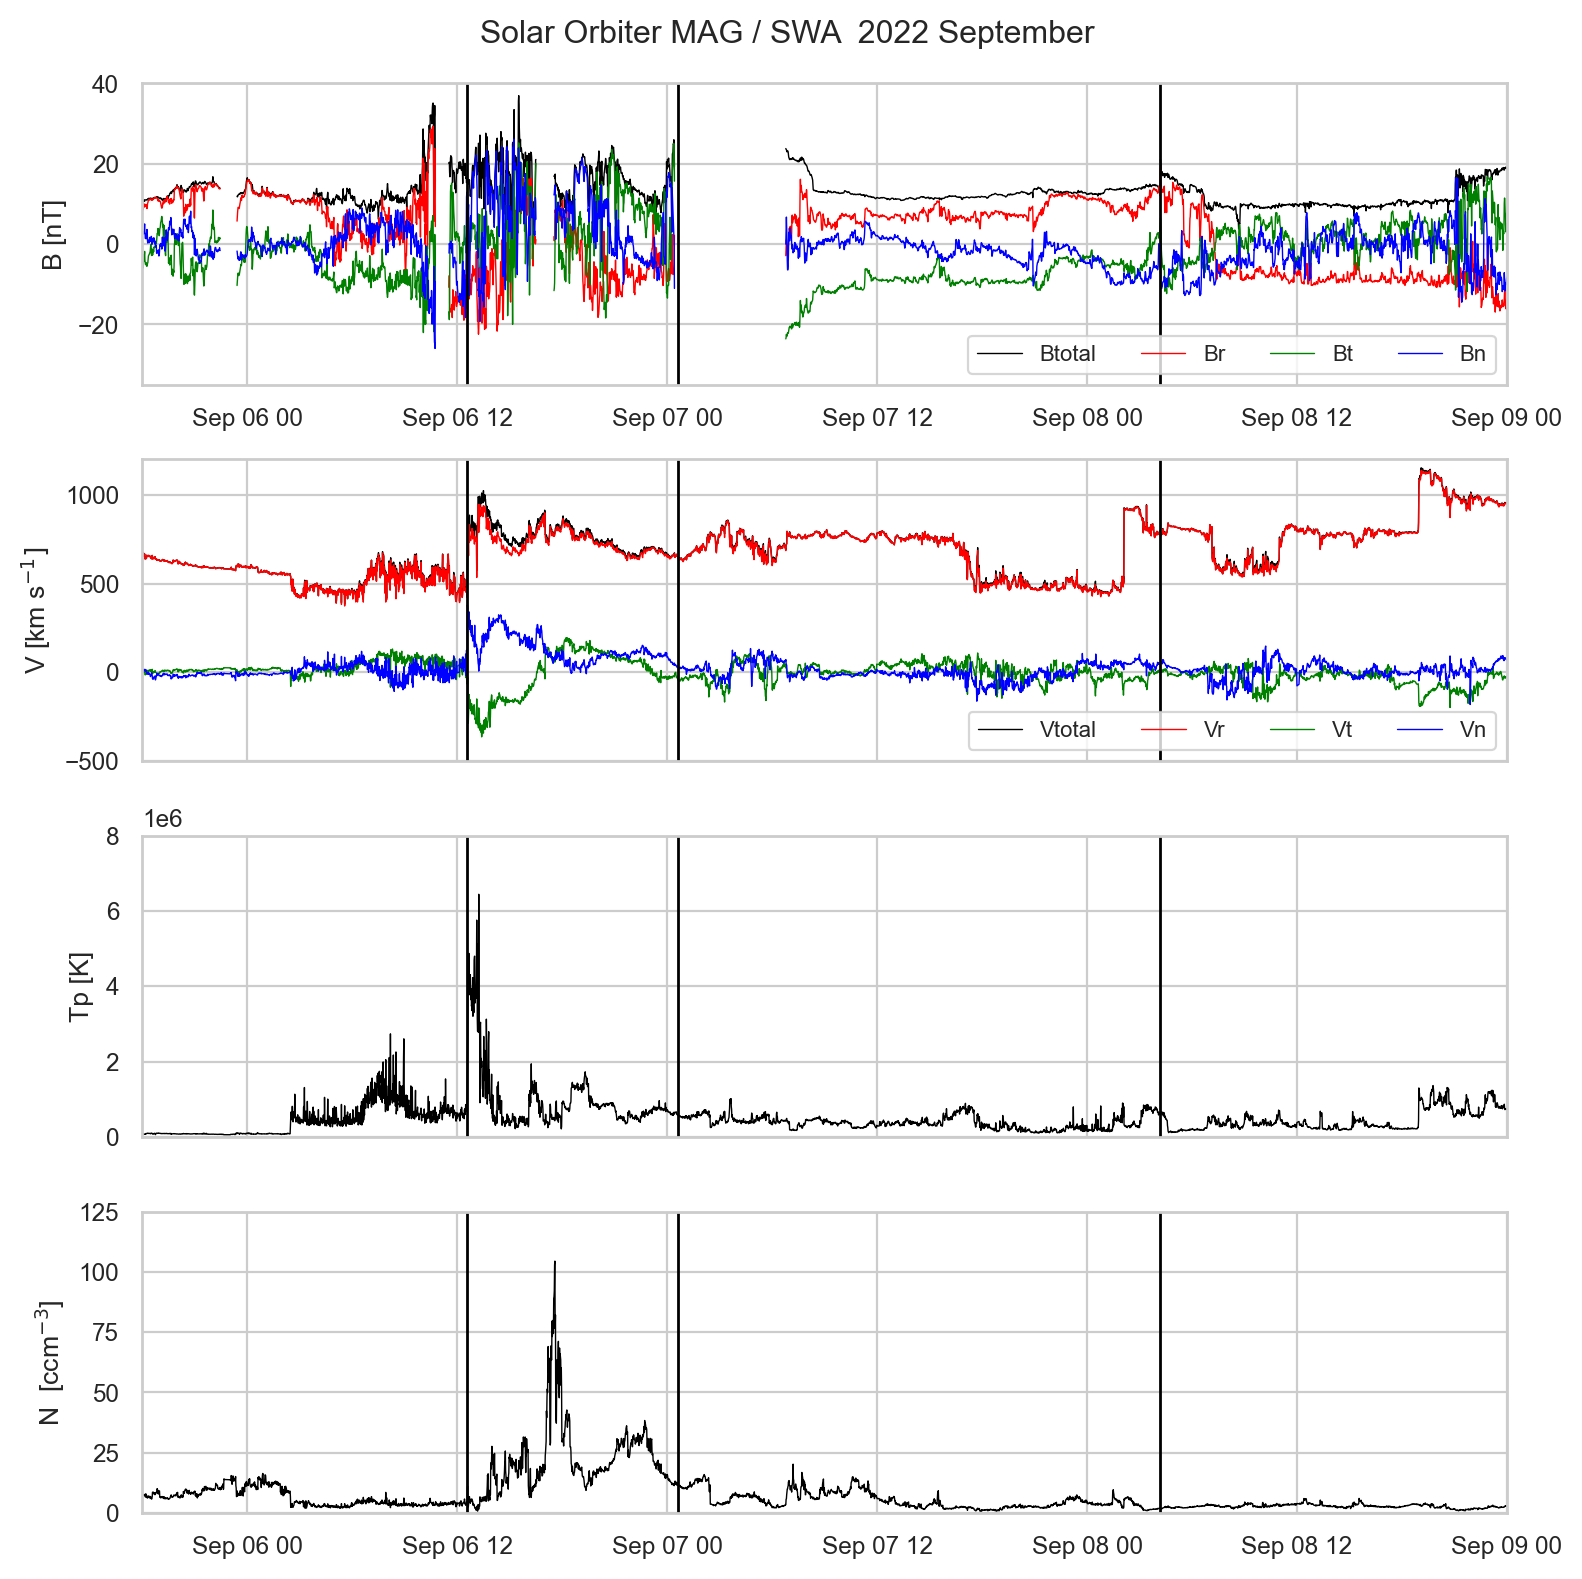

In [20]:
sns.set_style('whitegrid')
sns.set_context('paper')

%matplotlib inline



plt.figure(1,figsize=(8,8),dpi=200)

plt.suptitle('Solar Orbiter MAG / SWA  2022 September ')

ax1 = plt.subplot(411) 
ax1.plot(solo.time,solo.bt,color='black',lw=0.5, label='Btotal')
ax1.plot(solo.time,solo.bx,color='r',lw=0.5,label='Br')
ax1.plot(solo.time,solo.by,color='g',lw=0.5,label='Bt')
ax1.plot(solo.time,solo.bz,color='b',lw=0.5,label='Bn')
plt.ylabel('B [nT]')
ax1.legend(loc=4,ncol=4,fontsize=8)


ax2 = plt.subplot(412) 
plt.plot(solo.time,solo.vt, 'k',lw=0.5,label='Vtotal')
plt.plot(solo.time,solo.vx, 'r',lw=0.5,label='Vr')
plt.plot(solo.time,solo.vy, 'g',lw=0.5,label='Vt')
plt.plot(solo.time,solo.vz, 'b',lw=0.5,label='Vn')
ax2.set_ylabel('V [km s$^{-1}]$')
ax2.legend(loc=4,ncol=4,fontsize=8)
plt.setp(ax2.get_xticklabels(), visible=False)


ax3 = plt.subplot(413) 
plt.plot(solo.time, solo.tp, 'k', lw=0.5)
plt.ylabel('Tp [K]')
plt.setp(ax3.get_xticklabels(), visible=False)


ax4 = plt.subplot(414) 
plt.plot(solo.time, solo.np, 'k', lw=0.5)
plt.ylabel(r'N  [ccm$^{-3}$]')


plotstart=datetime.datetime(2022,9,5,18)
plotend=datetime.datetime(2022,9,9,0)
ax1.set_xlim(plotstart,plotend)
ax2.set_xlim(plotstart,plotend)
ax3.set_xlim(plotstart,plotend)
ax4.set_xlim(plotstart,plotend)

date_form = DateFormatter("%h %d %H")
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)
ax3.xaxis.set_major_formatter(date_form)
ax4.xaxis.set_major_formatter(date_form)


#plot vertical lines
ax1.plot_date([icme_start_time,icme_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([mo_start_time,mo_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([mo_end_time,mo_end_time],[-500,500],'-k',linewidth=1)  
ax1.set_ylim(-35,40)


ax2.plot_date([icme_start_time,icme_start_time],[-500,1500],'-k',linewidth=1)            
ax2.plot_date([mo_start_time,mo_start_time],[-500,1500],'-k',linewidth=1)            
ax2.plot_date([mo_end_time,mo_end_time],[-500,1500],'-k',linewidth=1)  
ax2.set_ylim(-500,1200)


ax3.plot_date([icme_start_time,icme_start_time],[-500,500*8e6],'-k',linewidth=1)            
ax3.plot_date([mo_start_time,mo_start_time],[-500,500*10e6],'-k',linewidth=1)            
ax3.plot_date([mo_end_time,mo_end_time],[-500,500*10e6],'-k',linewidth=1)  
ax3.set_ylim(0,8e6)

ax4.plot_date([icme_start_time,icme_start_time],[-500,500],'-k',linewidth=1)            
ax4.plot_date([mo_start_time,mo_start_time],[-500,500],'-k',linewidth=1)            
ax4.plot_date([mo_end_time,mo_end_time],[-500,500],'-k',linewidth=1)  
ax4.set_ylim(0,125)


plt.tight_layout()

plt.savefig('../lineups/solo_2022_sep_mag_plasma.png')
plt.savefig('../lineups/solo_2022_sep_mag_plasma.pdf')



print('done')

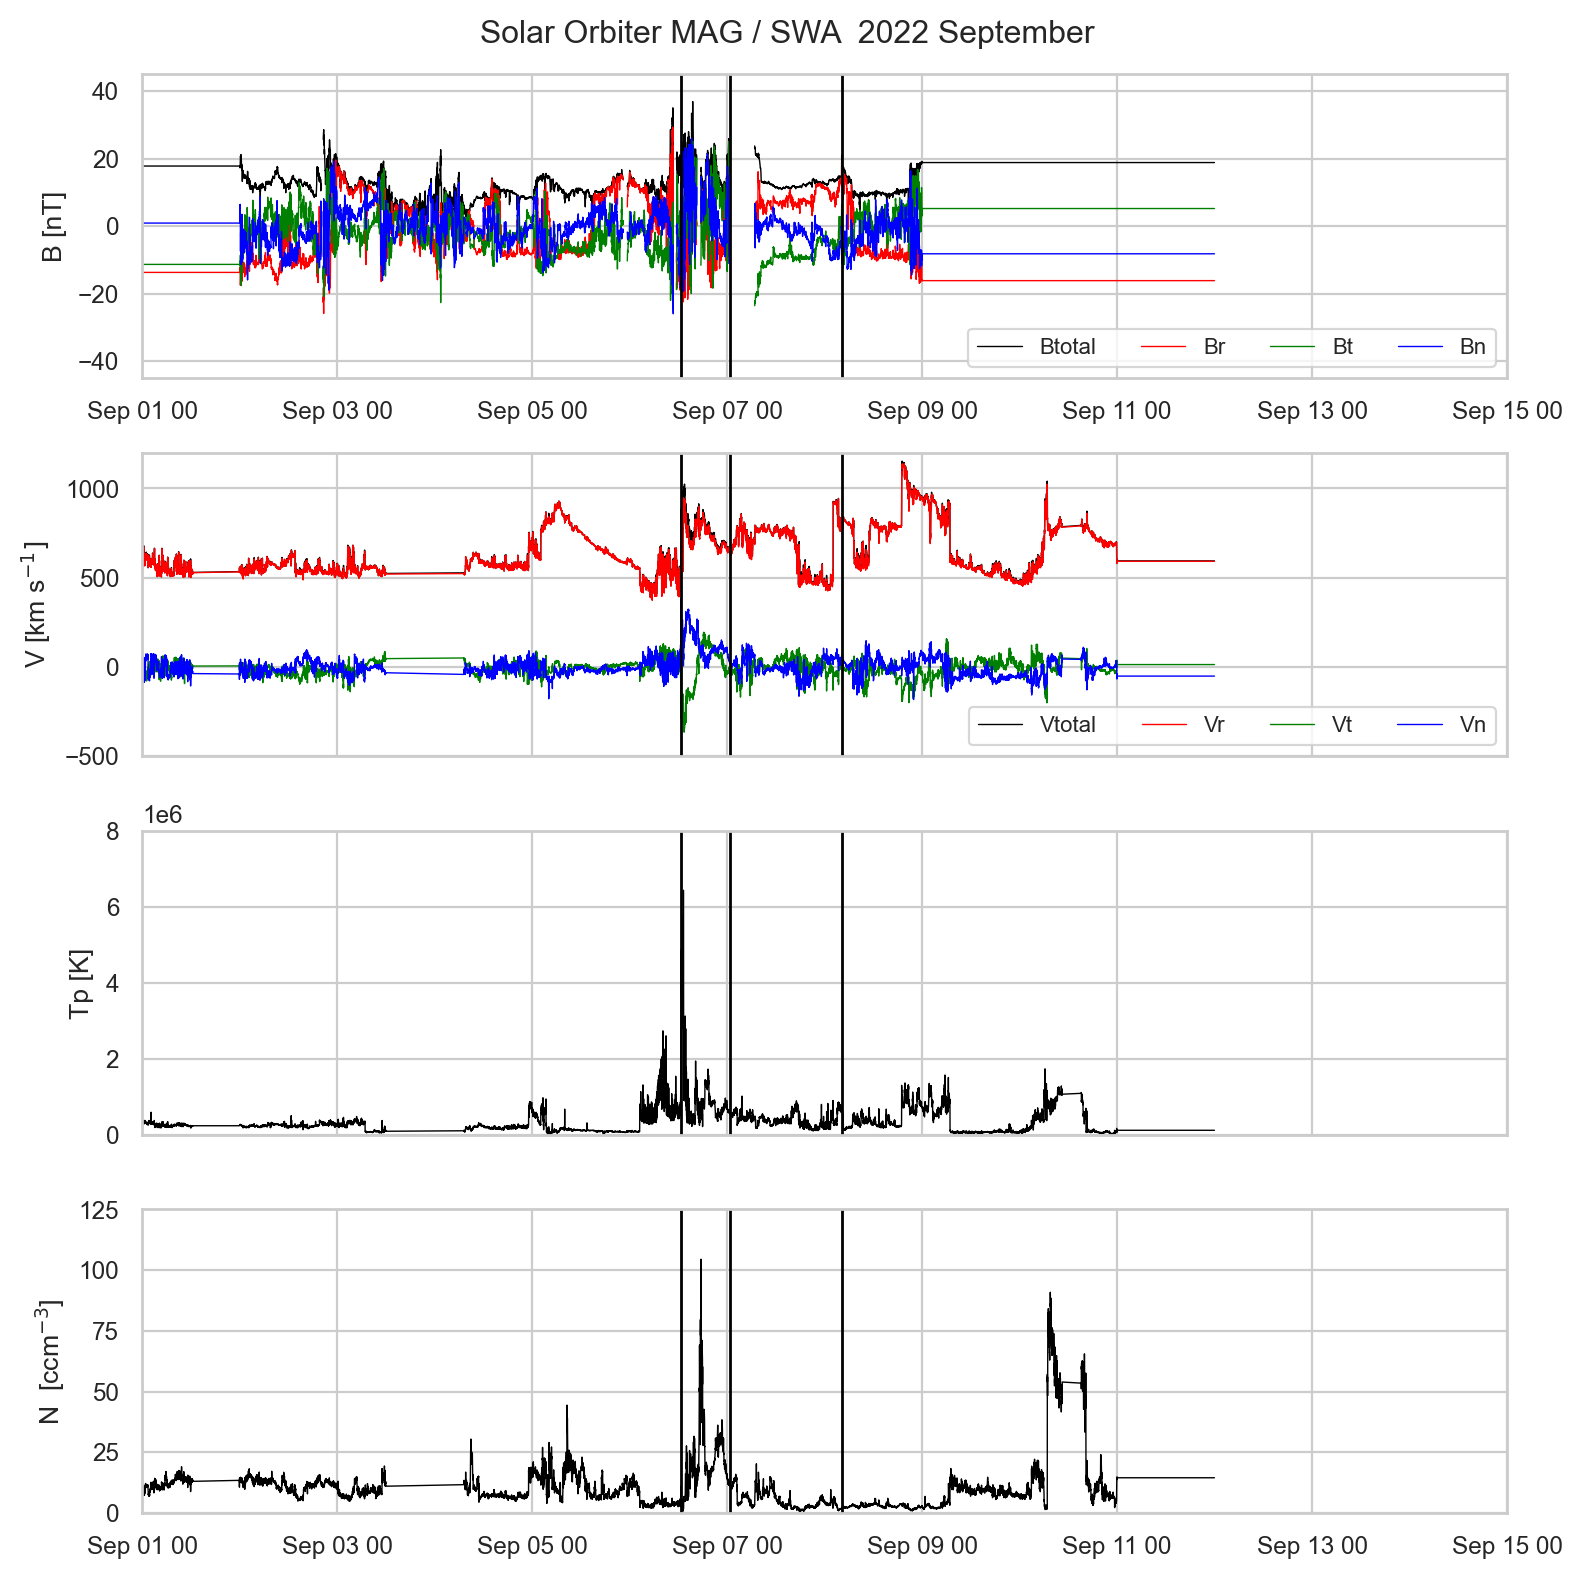

In [21]:
sns.set_style('whitegrid')
sns.set_context('paper')

%matplotlib inline

plt.figure(1,figsize=(8,8),dpi=200)

plt.suptitle('Solar Orbiter MAG / SWA  2022 September ')


ax1 = plt.subplot(411) 

ax1.plot(solo.time,solo.bt,color='black',lw=0.5, label='Btotal')
ax1.plot(solo.time,solo.bx, color='r',lw=0.5,label='Br')
ax1.plot(solo.time,solo.by,color='g',lw=0.5,label='Bt')
ax1.plot(solo.time,solo.bz,color='b',lw=0.5,label='Bn')
plt.ylabel('B [nT]')

ax1.legend(loc=4,ncol=4,fontsize=8)

ax2 = plt.subplot(412) 

plt.plot(solo.time,solo.vt, 'k',lw=0.5,label='Vtotal')
plt.plot(solo.time,solo.vx, 'r',lw=0.5,label='Vr')
plt.plot(solo.time,solo.vy, 'g',lw=0.5,label='Vt')
plt.plot(solo.time,solo.vz, 'b',lw=0.5,label='Vn')
ax2.set_ylabel('V [km s$^{-1}]$')
ax2.legend(loc=4,ncol=4,fontsize=8)
plt.setp(ax2.get_xticklabels(), visible=False)


ax3 = plt.subplot(413) 
plt.plot(solo.time, solo.tp, 'k', lw=0.5)
plt.ylabel('Tp [K]')
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = plt.subplot(414) 
plt.plot(solo.time, solo.np, 'k', lw=0.5)
plt.ylabel(r'N  [ccm$^{-3}$]')


plotstart=datetime.datetime(2022,9,1,0)
plotend=datetime.datetime(2022,9,15,0)
ax1.set_xlim(plotstart,plotend)
ax2.set_xlim(plotstart,plotend)
ax3.set_xlim(plotstart,plotend)
ax4.set_xlim(plotstart,plotend)

date_form = DateFormatter("%h %d %H")
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)
ax3.xaxis.set_major_formatter(date_form)
ax4.xaxis.set_major_formatter(date_form)


#plot vertical lines
ax1.plot_date([icme_start_time,icme_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([mo_start_time,mo_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([mo_end_time,mo_end_time],[-500,500],'-k',linewidth=1)  
ax1.set_ylim(-45,45)


ax2.plot_date([icme_start_time,icme_start_time],[-500,1500],'-k',linewidth=1)            
ax2.plot_date([mo_start_time,mo_start_time],[-500,1500],'-k',linewidth=1)            
ax2.plot_date([mo_end_time,mo_end_time],[-500,1500],'-k',linewidth=1)  
ax2.set_ylim(-500,1200)


ax3.plot_date([icme_start_time,icme_start_time],[-500,500*8e6],'-k',linewidth=1)            
ax3.plot_date([mo_start_time,mo_start_time],[-500,500*10e6],'-k',linewidth=1)            
ax3.plot_date([mo_end_time,mo_end_time],[-500,500*10e6],'-k',linewidth=1)  
ax3.set_ylim(0,8e6)

ax4.plot_date([icme_start_time,icme_start_time],[-500,500],'-k',linewidth=1)            
ax4.plot_date([mo_start_time,mo_start_time],[-500,500],'-k',linewidth=1)            
ax4.plot_date([mo_end_time,mo_end_time],[-500,500],'-k',linewidth=1)  
ax4.set_ylim(0,125)


plt.tight_layout()

plt.savefig('../lineups/solo_2022_sep_mag_plasma_wide.png')
plt.savefig('../lineups/solo_2022_sep_mag_plasma_wide.pdf')



## LASCO, STEREO coronagraph and PSP trajectory plots


### calculate PSP position


6481


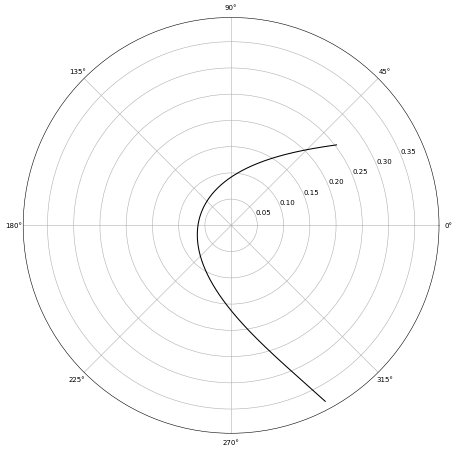

In [11]:
def cart2sphere(x,y,z):
    r = np.sqrt(x**2+ y**2 + z**2)           
    theta = np.arctan2(z,np.sqrt(x**2+ y**2))
    phi = np.arctan2(y,x)                    
    return (r, theta, phi)

starttime = datetime.datetime(2022, 9, 1)
endtime = starttime + timedelta(days=15)
psp_time2 = []
while starttime < endtime:
    psp_time2.append(starttime)
    starttime += timedelta(minutes=1) 

spice.furnish(spicedata.get_kernel('psp_pred'))
psp2=spice.Trajectory('SPP')
psp2.generate_positions(psp_time2, 'Sun','HEEQ')
psp2.change_units(astropy.units.AU)
[psp2_r, psp2_lat, psp2_lon]=cart2sphere(psp2.x,psp2.y,psp2.z)


fig=plt.figure(1, figsize=(19.2,10.8), dpi=50) #full hd
ax = plt.subplot2grid((1,1), (0, 0), rowspan=7, projection='polar')


plt.plot(psp2_lon,psp2_r,'k')


fs_start_ind=np.where(mdates.date2num(psp_time2) > mdates.date2num(datetime.datetime(2022, 9,5,12,0,0)))[0][0]
fs_end_ind=np.where(mdates.date2num(psp_time2) > mdates.date2num(datetime.datetime(2022, 9,7)))[0][0]
print(fs_start_ind)

#### get image data from HelioViewer


https://docs.sunpy.org/en/stable/guide/acquiring_data/helioviewer.html 

https://hvpy.readthedocs.io/en/stable/guide.html#basic-usage

https://docs.sunpy.org/en/latest/generated/gallery/units_and_coordinates/getting_lasco_observer_location.html




In [12]:
import hvpy
import sunpy.map
from sunpy.time import parse_time
from astropy.coordinates import SkyCoord

print(hvpy.__version__)

   
#hvpy.getDataSources() 


1.0.1


### SOHO LASCO C3

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
coordinates of observer  <Helioprojective Frame (obstime=2022-09-05T20:06:08.624, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-09-05T20:06:08.624, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 7.24351931, 1.50819746e+11)>)>
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


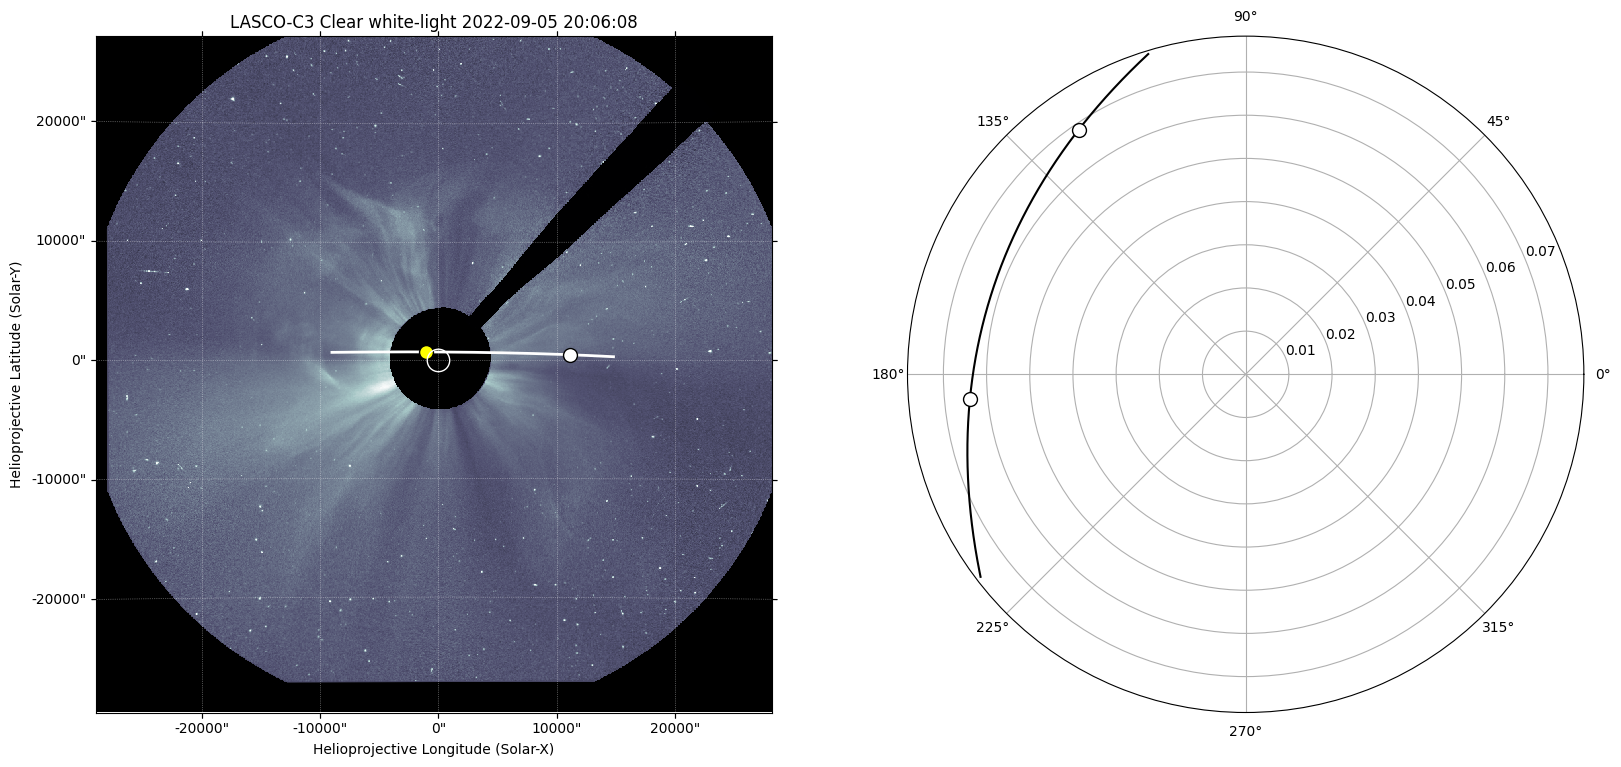

In [35]:
#lasco_file = hvpy.save_file(hvpy.getJP2Image(parse_time('2022/09/05 19:45').datetime, hvpy.DataSource.LASCO_C3.value), "data/lasco/lasco1.jpeg", overwrite=True)
#las = sunpy.map.Map(lasco_file)

las = sunpy.map.Map('data/lasco/lasco1.jpeg')

#lasrot = las.rotate(angle=-5 * u.deg)
#las.plot()

################################### plot 1

fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
ax1 = plt.subplot(121, projection=las)

print('coordinates of observer ',las.coordinate_frame)
#print(las.wcs)

#plot image
las.plot()
las.draw_limb()
#plt.colorbar()

#psp position as SkyCoord object
px=psp2.x[fs_start_ind:fs_end_ind]
py=psp2.y[fs_start_ind:fs_end_ind]
pz=psp2.z[fs_start_ind:fs_end_ind]
pc = SkyCoord(px, py, pz, frame='heliographic_stonyhurst',representation_type='cartesian')

ax1.plot_coord(pc, linestyle='solid', linewidth=2, color='white')

ax2 = plt.subplot(122, projection='polar')
ax2.plot(psp2_lon[fs_start_ind:fs_end_ind],psp2_r[fs_start_ind:fs_end_ind],'k')


#########


#where was PSP at CME arrival time?
psp_arrival_ind=np.where(mdates.date2num(psp_time2) > mdates.date2num(datetime.datetime(2022, 9,5,18,45,0)))[0][0]

px1=psp2.x[psp_arrival_ind]
py1=psp2.y[psp_arrival_ind]
pz1=psp2.z[psp_arrival_ind]
pc1 = SkyCoord(px1, py1, pz1, frame='heliographic_stonyhurst',representation_type='cartesian')

ax1.plot_coord(pc1, 'o', markersize=10, mec='black', mfc='white')
ax2.plot(psp2_lon[psp_arrival_ind],psp2_r[psp_arrival_ind],'o', markersize=10, mec='black', mfc='white')


solo_arrival_ind=np.where(mdates.date2num(psp_time2) > mdates.date2num(datetime.datetime(2022, 9,6,12,33,0)))[0][0]
px2=psp2.x[solo_arrival_ind]
py2=psp2.y[solo_arrival_ind]
pz2=psp2.z[solo_arrival_ind]
pc2 = SkyCoord(px2, py2, pz2, frame='heliographic_stonyhurst',representation_type='cartesian')

ax1.plot_coord(pc2, 'o', markersize=10, mec='black', mfc='yellow')
ax2.plot(psp2_lon[solo_arrival_ind],psp2_r[solo_arrival_ind],'o', markersize=10, mec='black', mfc='white')

### STEREO-A COR2

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
coordinates of observer  <Helioprojective Frame (obstime=2022-09-05T17:24:04.006, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-09-05T17:24:04.006, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-19.55655, 6.8236486, 1.4310943e+11)>)>
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


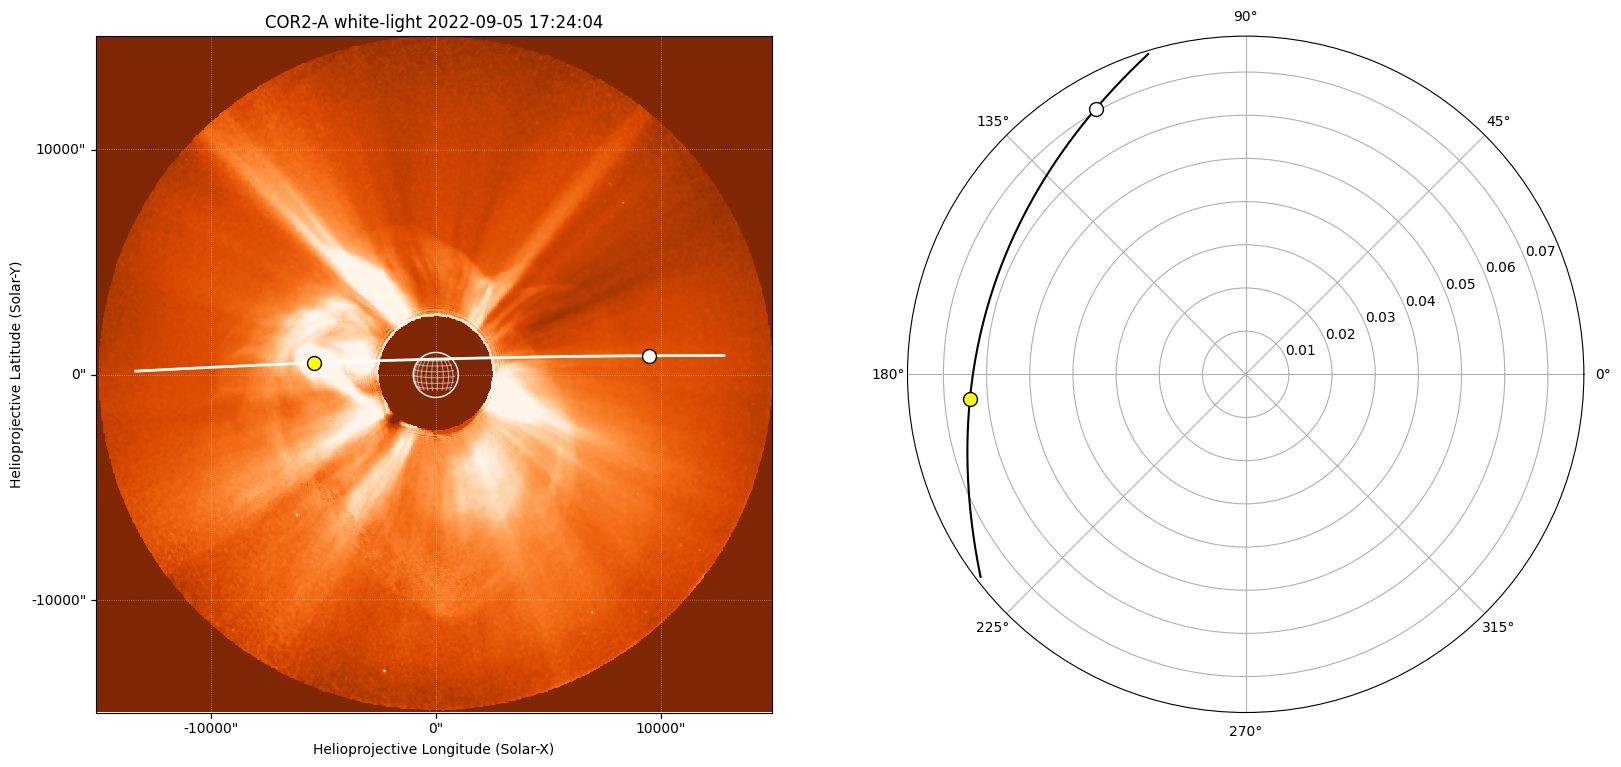

In [36]:
#cor2_file = hvpy.save_file(hvpy.getJP2Image(parse_time('2022/09/05 17:00').datetime, hvpy.DataSource.COR2_A.value), "data/lasco/cor2.jpeg", overwrite=True)
#cor2 = sunpy.map.Map(cor2_file)


cor2 = sunpy.map.Map("data/lasco/cor2.jpeg")


############################### plot 1

fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
ax1 = plt.subplot(121, projection=cor2)

print('coordinates of observer ',cor2.coordinate_frame)

#from skimage.exposure import equalize_hist
#cor2.set_data=equalize_hist(cor2.data)

#plot image
cor2.plot(cmap='Oranges_r', vmax=255)  #vmin, vmax
cor2.draw_limb()
cor2.draw_grid()
#plt.colorbar()

#psp position as SkyCoord object
px=psp2.x[fs_start_ind:fs_end_ind]
py=psp2.y[fs_start_ind:fs_end_ind]
pz=psp2.z[fs_start_ind:fs_end_ind]
pc = SkyCoord(px, py, pz, frame='heliographic_stonyhurst',representation_type='cartesian')

ax1.plot_coord(pc, linestyle='solid', linewidth=2, color='white')


ax2 = plt.subplot(122, projection='polar')
ax2.plot(psp2_lon[fs_start_ind:fs_end_ind],psp2_r[fs_start_ind:fs_end_ind],'k')




#where was PSP at CME arrival time?
psp_arrival_ind=np.where(mdates.date2num(psp_time2) > mdates.date2num(datetime.datetime(2022, 9,5,17,0,0)))[0][0]

px1=psp2.x[psp_arrival_ind]
py1=psp2.y[psp_arrival_ind]
pz1=psp2.z[psp_arrival_ind]
pc1 = SkyCoord(px1, py1, pz1, frame='heliographic_stonyhurst',representation_type='cartesian')

ax1.plot_coord(pc1, 'o', markersize=10, mec='black', mfc='white')
ax2.plot(psp2_lon[psp_arrival_ind],psp2_r[psp_arrival_ind],'o', markersize=10, mec='black', mfc='white')


solo_arrival_ind=np.where(mdates.date2num(psp_time2) > mdates.date2num(datetime.datetime(2022, 9,6,12,33,0)))[0][0]
px2=psp2.x[solo_arrival_ind]
py2=psp2.y[solo_arrival_ind]
pz2=psp2.z[solo_arrival_ind]
pc2 = SkyCoord(px2, py2, pz2, frame='heliographic_stonyhurst',representation_type='cartesian')

ax1.plot_coord(pc2, 'o', markersize=10, mec='black', mfc='yellow')
ax2.plot(psp2_lon[solo_arrival_ind],psp2_r[solo_arrival_ind],'o', markersize=10, mec='black', mfc='yellow')

### Source region location

coordinates of observer  <Helioprojective Frame (obstime=2022-08-22T18:45:09.350, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-08-22T18:45:09.350, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.00225528, 6.9561772, 1.5126508e+11)>)>


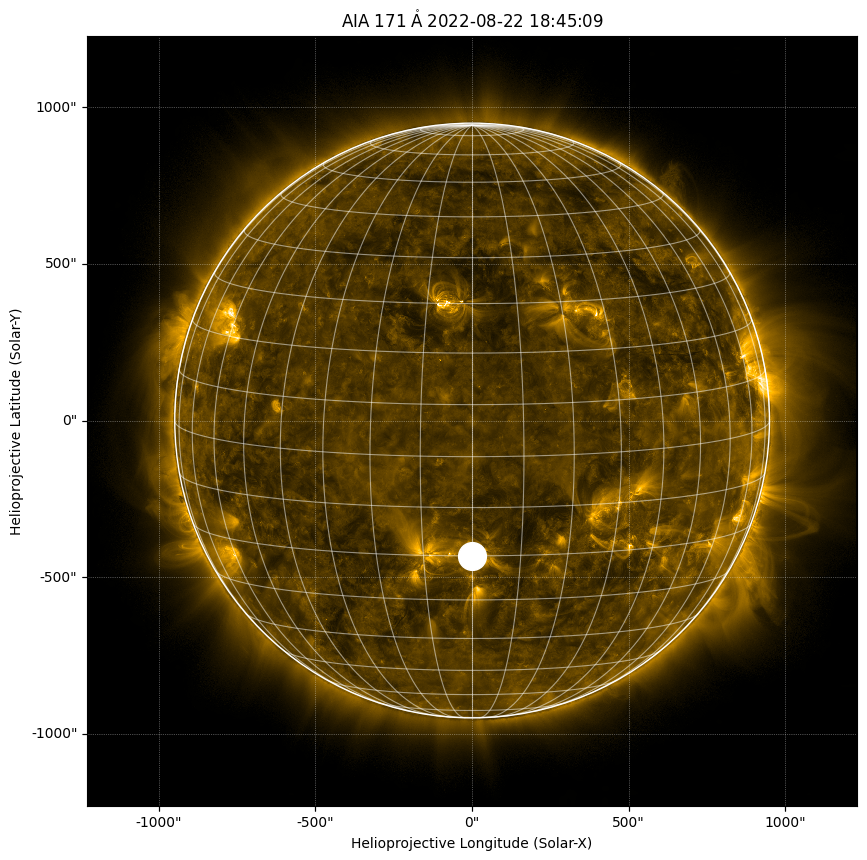

In [77]:
#sdo_file = hvpy.save_file(hvpy.getJP2Image(parse_time('2022/08/22 18:45').datetime, hvpy.DataSource.AIA_171.value), "data/lasco/aia.jpeg", overwrite=True)

sdo = sunpy.map.Map('data/lasco/aia.jpeg')
%matplotlib inline
#plt.ion()
################################### plot 1

from sunpy.coordinates import frames, get_horizons_coord

fig=plt.figure(1, figsize=(10,10)) 
ax1 = plt.subplot(111, projection=sdo)


print('coordinates of observer ',sdo.coordinate_frame)

#plot image
sdo.plot()
sdo.draw_limb()
sdo.draw_grid(grid_spacing=10*u.deg)
#plt.colorbar()


#plot position of W160 on 2022 Sep 5 17:00 on map


xc = [0] * u.deg
yc = [-20] * u.deg

#https://docs.sunpy.org/en/stable/guide/coordinates.html

coords = SkyCoord(xc, yc, frame=frames.HeliographicStonyhurst,obstime='2022-08-22 18:45')

#coords = SkyCoord(xc, yc, frame=frames.HeliographicStonyhurst,obstime='2022-08-22 18:45')

heeq_source = coords.transform_to(sdo.coordinate_frame)

ax1.plot_coord(heeq_source, 'ow', markersize=20)


#heeq_source


#coord = get_horizons_coord('Solar Orbiter', datetime.datetime('60m'})  
#solo_heeq = coord.transform_to(frames.HeliographicStonyhurst) #HEEQ
#solo_hee = coord.transform_to(frames.HeliocentricEarthEcliptic)  #HEE

#solo_time=solo_heeq.obstime.to_datetime()
#solo_r=solo_heeq.radius.value
#solo_lon=np.deg2rad(solo_heeq.lon.value)
#solo_lat=np.deg2rad(solo_heeq.lat.value)

#measure source region coordinates

#def onclick(event):
#    print(event.xdata,event.ydata)

#cid = fig.canvas.mpl_connect('button_press_event', onclick)


#coords = SkyCoord(xc, yc, frame=smap.coordinate_frame)


## TO DO: read original fits files

In [17]:
from sunpy.net import Fido, attrs as a

#a. Time('2022/9/5', '2022/9/6')
#print(a.Instrument)

result = Fido.search(a.Time('2022/9/5 16:00', '2022/9/5 19:00'), a.Instrument.secchi) 
print(result)
#downloaded_files = Fido.fetch(result[0, 0]) 


result = Fido.search(a.Time('2022/9/5 16:00', '2022/9/5 20:00'), a.Instrument.lasco, a.Level.two) 

print(result)



Results from 1 Provider:

101 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 619.157 Mbyte

       Start Time       ...                  Info                
                        ...                                      
----------------------- ... -------------------------------------
2022-09-05 16:00:00.000 ...  COR1 ;  ; NORMAL ; 240deg. ; 512x512
2022-09-05 16:00:30.000 ...          EUVI ;  ; NORMAL ; 2048x2048
2022-09-05 16:03:00.000 ...          EUVI ;  ; NORMAL ; 2048x2048
2022-09-05 16:05:12.000 ...  COR1 ;  ; SERIES ; 120deg. ; 512x512
2022-09-05 16:05:30.000 ...          EUVI ;  ; NORMAL ; 2048x2048
2022-09-05 16:09:01.000 ...           HI1 ;  ; SERIES ; 1024x1024
                    ... ...                                   ...
2022-09-05 18:49:01.000 ...           HI1 ;  ; SERIES ; 1024x1024
2022-09-05 18:50:00.000 ... COR1 ;  ; NORMAL ; 1001deg. ; 512x512
2022-09-05 18:50:30.000 ...          EUVI ;  ; NORMAL ; 2048x2048


In [ ]:

#img, hr = fits.getdata(f, header=True)
#img = img


#### calculate Carrington Longitude for PSP and SolO

